# Google Work Hours
Extracts work hours based on location data.
Registers the earliest and latest entry per day for a specific geospatial location, the work place.
Based on this it calculates the length of the work day.

In [160]:
# -*- coding: utf-8 -*-
from folium import Map, Marker, Icon, Circle
import pandas as pd
import json
from datetime import datetime, timezone
from latlon_to_utm import GPStoUTM
import math
from pyproj import Proj, transform
import matplotlib

def coordConv(Lat, Long):
    lat = float(int(Lat)/(10**7))
    long = float(int(Long)/(10**7))
    return [lat, long]

#def euclid( origo, pos ):
#    return math.dist( origo, pos )


origoTs = datetime.strptime("20210831", '%Y%m%d').replace(tzinfo=timezone.utc)


gps = GPStoUTM()
CoordWork = [61.15141817489847, 10.418270074136728]
CoordWorkM = gps.LLtoUTM(CoordWork[0], CoordWork[1])


## Import location data file
Location data is regularly altered.  Two version of timestamp information is parsed currently and three fields are used, timestamp, latitude and longtitude.

In [161]:
LocationDataFile = input("Data file:")
if not LocationDataFile:
    LocationDataFile = "./exported-location-data-20220318/Location History/Records.json"
    #LocationDataFile = "./exported-location-data-20211203/Location History/Location History.json"
    
with open(LocationDataFile, "r") as F:
    JsonData = json.loads( F.read().strip() )["locations"]
df = pd.DataFrame( JsonData )

Data file:


## Load data
loads the data and parses its location info into dasets per day.

In [162]:
#Plot
source_columns = df.columns
timestampColumn = "timestampMs" if "timestampMs" in source_columns else "timestamp"
cols = ["latitudeE7","longitudeE7", timestampColumn]
if timestampColumn == "timestamp":
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f' )
    
EuclidHist = []
dailySets  = {}
preKey     = 0
for index, row in df[cols].iterrows():
    if timestampColumn == "timestampMs":
        row["timestampMs"] = datetime.fromtimestamp( int(row.timestampMs)/1000.0 )
    
    if row[timestampColumn] < origoTs:
        continue
        
    ts = row[timestampColumn]
    key = int( ts.strftime("%Y%m%d") )
    if key != preKey and key not in dailySets:
        dailySets.update({key:[]})
            
    tmpCoord  = coordConv(row.latitudeE7, row.longitudeE7)
    tmpCoordM = gps.LLtoUTM(tmpCoord[0], tmpCoord[1])
    
    eu = math.dist( CoordWorkM, tmpCoordM )
    EuclidHist.append(eu)
    
    dailySets[key].append({
        "lat":       tmpCoord[0], "long":      tmpCoord[1],
        "euclid":    eu, "timestamp": ts
    })
print( len(EuclidHist) )

60561


## Euclid distance from origo coordinate

60561


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

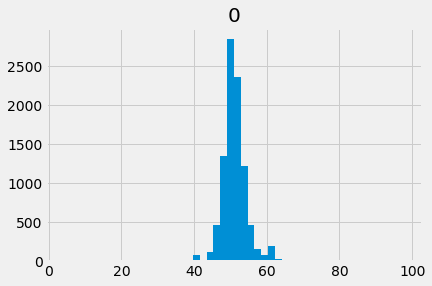

In [163]:
print(len(EuclidHist))

dfHist = pd.DataFrame( EuclidHist )
dfHist[dfHist[0] < 100].hist(bins=50)

In [164]:
maxEuclid = 250
minEuclid = 75
workHours = {}
popuptxt = "{}\n[{}:{}]"

my_map = Map(location=CoordWork, zoom_start=18)

Circle(location=CoordWork, radius=minEuclid,
                    popup='Work Area', line_color='black',
                    fill_color='green', fill_opacity=0.5).add_to(my_map)

for day in dailySets:
    if day < 20210901:
        continue
    tsFirst = None
    tsLast = None
    for event in dailySets[day]:
        if event["euclid"] < maxEuclid:
            if event["euclid"] < minEuclid:
                if not tsFirst:
                    tsFirst = event
                    tsLast = event
                else:
                    if tsLast["timestamp"] < event["timestamp"]:
                        tsLast = event
    if tsFirst and tsLast:
        Marker( location=[tsFirst["lat"],tsFirst["long"]], icon=Icon(color="green"),
                popup=popuptxt.format(tsFirst["timestamp"], tsFirst["lat"],tsFirst["long"] ) ).add_to(my_map)
        Marker( location=[tsLast["lat"],tsLast["long"]], icon=Icon(color="red"),
                popup=popuptxt.format(tsLast["timestamp"], tsLast["lat"],tsLast["long"] ) ).add_to(my_map)
        
    workHours.update({day: [tsFirst,tsLast]})

my_map

In [165]:
hours = []
day_min = None
day_max = None
for day in workHours:
    date = datetime.strptime( str(day), "%Y%m%d" )
    if day_min == None or day_min > date:
        day_min = date
    if day_max == None or date > day_max:
        day_max = date
        
    weekend = True if date.weekday() >= 5 else False
        
    if workHours[day][0] is None or workHours[day][1] is None:
        minHours = None
        hours.append({"date":date.strftime("%Y%m%d"), 
                      "start":None, 
                      "end":None, 
                      "minutes":0.0, 
                      "weekend":weekend, 
                      "7.5h":None})
    else:
        start = workHours[day][0]["timestamp"]
        end   = workHours[day][1]["timestamp"]
        minHours = True if (((end-start).seconds/3600.0) > 7.5) else False
        hours.append({"date":date.strftime("%Y%m%d"), 
                      "start":start.strftime("%Y%m%d_%H%M"), 
                      "end":end.strftime("%Y%m%d_%H%M"), 
                      "minutes":(end-start).seconds/60.0, 
                      "weekend":weekend, 
                      "7.5h":minHours})

        
dfHours = pd.DataFrame(hours)
dfHours.to_excel("workHours-{}-{}.xlsx".format(datetime.strftime( day_min, "%Y%m%d" ),
                                                datetime.strftime( day_max, "%Y%m%d" )),
                                                 sheet_name="Work Hours", header=True, index=False)
dfHours.head()

,date,start,end,minutes,weekend,7.5h
0,20210901,20210901_0617,20210901_1527,549.766667,False,True
1,20210902,20210902_0618,20210902_1518,540.150000,False,True
2,20210903,20210903_0629,20210903_1439,489.733333,False,True
3,20210904,None,None,0.000000,True,None
4,20210905,None,None,0.000000,True,None


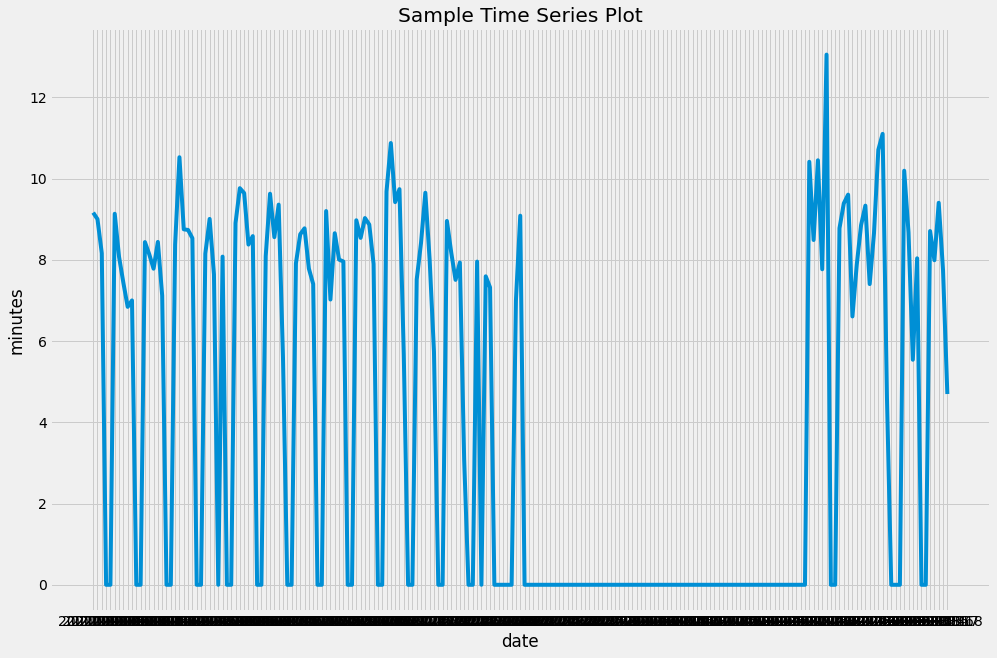

In [166]:
dfA = dfHours.set_index("date")
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 10))
plt.xlabel("date")
plt.ylabel("minutes")
plt.title("Sample Time Series Plot")
plt.plot(dfA["minutes"]/60)
